# Lesson 28: The Luria-Delbrück distribution

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l28_ld_dist.ipynb).*

In [1]:
# NumPy, of course
import numpy as np

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

In this tutorial, we will use your newfound computational skills to analyze a classic problem in biology.

When mutations occur in nature, they are often deleterious to the organism. However, mutations are a critical part of the genetic heritage of living organisms, arising in every type of organism and allowing life to evolve and adapt to new environments.  In 1943, the question of how microorganisms acquire mutations was described in a famous article by Salvador Luria and Max Delbrück ([S. E. Luria and M. Delbrück, *Genetics*, **28**, 491–511, 1943](http://www.genetics.org/content/28/6/491.full.pdf)). At the time, there were two prominent theories of genetic inheritance. Scientists did not know if mutations arose randomly in the absence of an environmental cue, the "random mutation hypothesis", or whether they occur as an adaptive response to an environmental stimulus, the "adaptive immunity hypothesis." See the figure below.

<br />
![Competing hypotheses](ld_hypotheses.png)
<br />

To test these two hypotheses, Luria and Delbrück grew many parallel cultures of bacteria and then plated each culture on agar containing phages (which infect and kill nearly all of the bacteria). Although most bacteria are unable to survive in the presence of phages, often mutations could enable a few survivors to give rise to resistant mutant colonies. If the adaptive immunity hypothesis is correct, mutations occur only after bacteria come in contact with phages, thus only after plating the bacteria on phage-agar plates.  Under the random mutation hypothesis, some bacteria already have the immunity before being exposed.

The number of colonies that survive after plating is the number of cells, $n$ that survived.  In this lesson, we will compute the probability mass function, $P(n;N, r)$, describing the probability that $n$ cells out of a total of $N$ survive, given that the mutation rate is $r$ mutations per cell per replication.  We will do this for both hypotheses.

## The adaptive immunity hypothesis
Under the adaptive immunity hypothesis, no cells undergo mutations prior to exposure to phage.  Upon exposure, the probability that a given cell mutates is $r$.  What is the probability that $n$ out of a total of $N$ cells is mutated?  There are two components to this probability.  First, there is the chance that cells 1 through $n$ are mutated and cells $n+1$ through $N$ are not.  Since
the cells have independent chances of mutation, this is $r^n(1-r)^{N-n}$.  But, we arbitrarily labeled the cells.  We have to also take into account the number of ways to label the cells that are mutated.  There are

\begin{align}
\begin{pmatrix}N \\ n \end{pmatrix} = \frac{N!}{n!(N-n)!}
\end{align}

(pronounced "$N$ choose $n$") waysto do this.  Thus, we have

\begin{align}
  P_{ai}(n;N, r) = \frac{N!}{n!(N-n)!}\,r^n(1-r)^{N-n},
\end{align}

the probability of having exactly $n$ out of $N$ cells be mutated. This probability distribution is called the **binomial distribution**.

## The random mutation hypothesis
The probability distribution for the random mutation hypothesis (the so-called Luria-Delbrück distribution) is much more difficult to calculate.  Luria and Delbrück computed it asymptotically.  Its exact form was not derived until six years after the Luria-Delbrück experiment by Lea and Coulson.  The resulting expression for the distribution is a giant mess and very difficult to interpret.  An easier way to compute the distribution, now that we have powerful computers, is to *simulate* the process of acquiring mutations with a Monte Carlo simulation.  We are then sampling out of the probability distribution and we can therefore compute the approximate distribution.

## Sampling the distributions
We will now write code to sample the distributions and compute the means and variances of the distributions.  In our calculations, we assume $N \propto t \propto g$, where $t$ is the amount of time the bacteria grew before innoculations, and $g$ is the number of generations that occured during that growth.  So, we can treat $N$ as the same for each of the hypotheses.

For our sampling, we will assume the experiment was done after 16 generations (for a total of $N = 2^{15} \approx 1$ million cells) with a mutation rate of $10^{-5}$.

In [2]:
# Specify parameters
n_gen = 16
r = 1e-5

# Total number of cells
n_cells = 2**(n_gen - 1)

### The adaptive immunity hypothesis
We already know that the adaptive mutation hypothesis results in the number of survivors being binomially distributed, so there is really no need to sample the distribution.  We also already know the mean and variance, which we can compute analytically (or look up on Wikipedia).

\begin{align}
\text{mean} &= \langle n \rangle = Nr \\
\text{variance} &= Nr(1-r) \approx Nr \text{ for } r \ll 1.
\end{align}

So, the ratio of the mean to the variance, the so-called **Fano factor** is approximately unity.

Nonetheless, just for fun, we will sample out of the binomial distribution.  The `np.random.binomial()` function allows us to do this.  Let's take 100,000 samples.

In [3]:
# Draw 100000 binomial samples
ai_samples = np.random.binomial(n_cells, r, 100000)

We can compute the mean, variance, and Fano factor for the adaptive immunity hypothesis.

In [4]:
print("""
Adaptive immunity hypothesis
----------------------------
mean:        {mean:.4f}
variance:    {var:.4f}
Fano factor: {fano:.4f}
""".format(mean=ai_samples.mean(), var=ai_samples.std()**2,
           fano=ai_samples.std()**2 / ai_samples.mean()))


Adaptive immunity hypothesis
----------------------------
mean:        0.3245
variance:    0.3250
Fano factor: 1.0016



These are, of course, what we expect for the binomial distribution.  Importantly, the Fano factor is always expected to be unity, regardless of the mutation rate.  If we plot a histogram of the distribution, we will also find it is binomial.

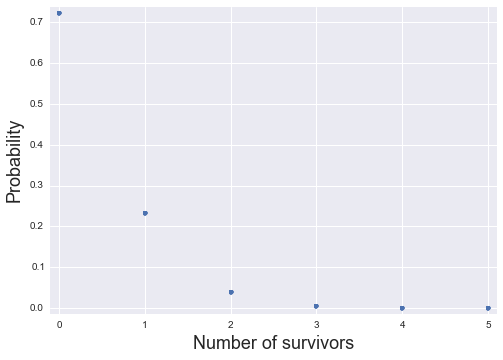

In [5]:
# Plot histogram, but it's a probability mass function, so no need for bins
plt.plot(np.bincount(ai_samples) / len(ai_samples), marker='.', markersize=10,
        linestyle='None')

plt.xlabel('Number of survivors')
plt.ylabel('Probability')
plt.xticks(np.arange(ai_samples.max()+1));
plt.margins(0.02)

### The random mutation hypothesis
For the random mutation hypothesis, we note that each generation may have mutations.  The number of mutations, as we just learned, is binomally distributed.  So, for each generation, we need to draw a number of mutants from a binomial distribution.  The number of possible cells that can have the mutation is equal to those who have not already mutated.  I.e., the number of cells that can have a mutation in generation $g$ is

\begin{align}
N_g = 2^g - 2n_{g-1},
\end{align}

where $g$ is the generation and $n_{g-1}$ is the number of mutant cells in generation $g-1$.  We are just subtracting out the cells that have already mutated. 

In [6]:
def draw_random_mutation(n_gen, r):
    """Draw a sample out of the Luria-Delbruck distribution"""
    # Initialize number of mutants
    n_mut = 0
    
    for g in range(n_gen):
        n_mut = 2 * n_mut + np.random.binomial(2**g - 2 * n_mut, r)
        
    return n_mut


def sample_random_mutation(n_gen, r, n_samples):
    """Sample out of the Luria-Delbruck distribution"""
    # Initialize samples
    samples = np.empty(n_samples)
    
    # Draw the samples
    for i in range(n_samples):
        samples[i] = draw_random_mutation(n_gen, r)
        
    return samples

Because compiling it with `numba` is trivial, we add the `numba` compilation decorators.  Let's go ahead and draw 100,000 samples.

In [7]:
rm_samples = sample_random_mutation(n_gen, r, 100000).astype(int)

In [8]:
print("""
Random mutation hypothesis
--------------------------
mean:        {mean:.4f}
variance:    {var:.4f}
Fano factor: {fano:.4f}
""".format(mean=rm_samples.mean(), var=rm_samples.std()**2,
           fano=rm_samples.std()**2 / rm_samples.mean()))


Random mutation hypothesis
--------------------------
mean:        5.9032
variance:    42154.5811
Fano factor: 7141.0075



Wow!  The Fano factor is huge!  Even though the mean is small, we have samples that have a huge number of survivors.  This makes sense, as a cell may acquire a mutation in an early generation, and this then gets propagated forward in time.  Let's plot the distribution.

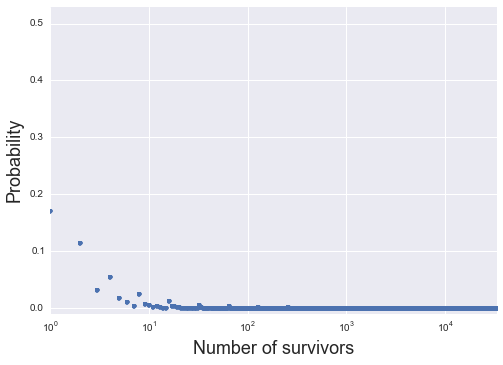

In [9]:
# Plot histogram, but it's a probability mass function, so no need for bins
plt.semilogx(np.bincount(rm_samples.astype(int)) / len(rm_samples), 
             marker='.', markersize=10, linestyle='None')

plt.xlabel('Number of survivors')
plt.ylabel('Probability')
plt.margins(0.02)

We can also plot the cumulative distribution.

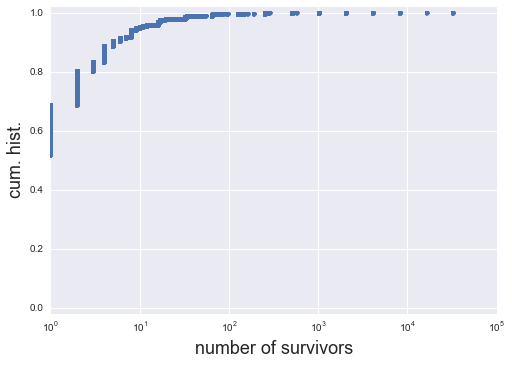

In [10]:
# Sort the samples
rm_samples = np.sort(rm_samples)

# Generate y-axis for CDF
y = np.arange(len(rm_samples)) / len(rm_samples)

# Plot CDF from random numbers
plt.semilogx(rm_samples, y, '.', markersize=10)
t_smooth = np.logspace(0.5, 8, 100)

# Clean up plot
plt.margins(y=0.02)
plt.xlabel(r'$t_{bt} (s)$')
plt.ylabel('cum. hist.')

# Clean up plot
plt.margins(y=0.02)
plt.xlabel('number of survivors')
plt.ylabel('cum. hist.')

We see that most trials, about 50%, have no survivors.  But we also see that the distribution has a very long tail!  So, regardless of what the mutation rate is, we expect to see long tails in the random mutation hypothesis.  If we observe a plate with a a large number of colonies, we know we are sampling in the tail of the Luria-Delbrück distribution.  The probability of seeing large numbers of survivors is vanishingly small under the adaptive immunity hypothesis.